# Components

```{glue:figure} NTR_components_stds
:scale: 50%
:align: right
```

In this notebook we'll explore the various contributions to high and low water levels. At the moment this is exploratory - we are using this to take broad stroke looks. We'll do this by breaking down the time series of hourly water levels at a tide gauge into different frequency bands, with the idea that certain processes fall within these timescales. For example, we know that ENSO timescales are roughly 4-7 years. We know that PDO timescales are closer to decadal, and mesoscale eddies are weeks-months. 

```{caution}
THIS IS VERY MUCH a work in progress. Please do not consider any of this final.
```

In [282]:
%run setup.ipynb
%run plotting_functions.ipynb
%run tseries_functions.py

In [2]:
from utide import solve, reconstruct
import xarray as xr

/Users/juliafiedler/anaconda3/envs/SLI39/lib/python3.9/site-packages/utide/harmonics.py:16: RuntimeWarning: invalid value encountered in cast
  nshallow = np.ma.masked_invalid(const.nshallow).astype(int)
/Users/juliafiedler/anaconda3/envs/SLI39/lib/python3.9/site-packages/utide/harmonics.py:17: RuntimeWarning: invalid value encountered in cast
  ishallow = np.ma.masked_invalid(const.ishallow).astype(int) - 1


In [3]:
ds = xr.open_dataset(data_dir / 'rsl_hawaii.nc')

For right now, we'll do Kahului.

In [661]:
epoch_start = np.datetime64('1983-01-01')
epoch_end = np.datetime64('2001-01-01')
ds_epoch = ds.sel(time=slice(epoch_start, epoch_end))

#extract time and sea level values for HNL station
time = ds_epoch.time.values
time_days = (time - time[0]) / np.timedelta64(1, 'D')

#select only station 59
station = 50
sea_level = ds_epoch.sea_level.sel(record_id=station
                       ).values
station_name = ds_epoch.station_name.sel(record_id=station).item()
print(f'Working on station: {station_name}')

mhhw = ds.MHHW.sel(record_id=station).values





Working on station: Midway


In [662]:
ds

<xarray.Dataset> Size: 55MB
Dimensions:               (time: 1052654, record_id: 11)
Coordinates:
  * time                  (time) datetime64[ns] 8MB 1905-01-01T10:00:00 ... 2...
  * record_id             (record_id) int64 88B 14 50 52 57 ... 61 547 548 552
Data variables:
    sea_level             (record_id, time) float32 46MB ...
    lat                   (record_id) float32 44B ...
    lon                   (record_id) float32 44B ...
    station_name          (record_id) <U17 748B ...
    station_country       (record_id) <U30 1kB ...
    station_country_code  (record_id) float32 44B ...
    uhslc_id              (record_id) float32 44B ...
    gloss_id              (record_id) float32 44B ...
    ssc_id                (record_id) <U4 176B ...
    last_rq_date          (record_id) datetime64[ns] 88B ...
    MHHW                  (record_id) float64 88B ...
    MSL                   (record_id) float64 88B ...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2025-03-03T14:27:41Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

Estimate the astronomical tides at this location using the selected epoch.

In [663]:
coef_noNodal = solve(time, sea_level, nodal=False, trend=True, method='robust',lat=ds['lat'].sel(record_id=station).values)
coef_Nodal = solve(time, sea_level, nodal=True, trend=True, method='robust',lat=ds['lat'].sel(record_id=station).values)

solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.


In [664]:
time_ALL = ds.time.values
sea_level_ALL = ds.sea_level.sel(record_id=station).values

# find beginning of data in timeseries
start = np.where(~np.isnan(sea_level_ALL))[0][0]
time_ALL = time_ALL[start:]
sea_level_ALL = sea_level_ALL[start:]

tide_ALL_withNodal = reconstruct(time_ALL, coef_Nodal)
tide_ALL_noNodal = reconstruct(time_ALL, coef_noNodal)


ntr = sea_level_ALL - tide_ALL_withNodal.h
ntr_withNodal = sea_level_ALL - tide_ALL_noNodal.h
nodal_pred = tide_ALL_withNodal.h - tide_ALL_noNodal.h
ntr_data = pd.DataFrame({'time': time_ALL, 'ntr': ntr, 'sea_level': sea_level_ALL, 'tide': tide_ALL_withNodal.h, 'nodal': nodal_pred, 'ntr_withNodal': ntr_withNodal})
ntr_data
# ntr_data.to_csv('data/ntr_057b.csv', index=False)

prep/calcs ... done.
prep/calcs ... done.


,time,ntr,sea_level,tide,nodal,ntr_withNodal
0,1947-02-08 04:00:00,219.991209,1189.0,969.008791,-12.397006,207.594203
1,1947-02-08 05:00:00,255.132164,1250.0,994.867836,-16.478207,238.653958
2,1947-02-08 06:00:00,267.260455,1250.0,982.739545,-18.188605,249.071850
3,1947-02-08 07:00:00,284.731082,1219.0,934.268918,-18.475715,266.255367
4,1947-02-08 08:00:00,293.956199,1158.0,864.043801,-18.088657,275.867542
...,...,...,...,...,...,...
683583,2025-01-31 19:00:00,22.369370,1317.0,1294.630630,8.408938,30.778308
683584,2025-01-31 20:00:00,10.499296,1240.0,1229.500704,11.343860,21.843156
683585,2025-01-31 21:00:00,6.865975,1159.0,1152.134025,12.839269,19.705243
683586,2025-01-31 22:00:00,-1.348111,1080.0,1081.348111,12.557502,11.209391


In [665]:
ntr_data

,time,ntr,sea_level,tide,nodal,ntr_withNodal
0,1947-02-08 04:00:00,219.991209,1189.0,969.008791,-12.397006,207.594203
1,1947-02-08 05:00:00,255.132164,1250.0,994.867836,-16.478207,238.653958
2,1947-02-08 06:00:00,267.260455,1250.0,982.739545,-18.188605,249.071850
3,1947-02-08 07:00:00,284.731082,1219.0,934.268918,-18.475715,266.255367
4,1947-02-08 08:00:00,293.956199,1158.0,864.043801,-18.088657,275.867542
...,...,...,...,...,...,...
683583,2025-01-31 19:00:00,22.369370,1317.0,1294.630630,8.408938,30.778308
683584,2025-01-31 20:00:00,10.499296,1240.0,1229.500704,11.343860,21.843156
683585,2025-01-31 21:00:00,6.865975,1159.0,1152.134025,12.839269,19.705243
683586,2025-01-31 22:00:00,-1.348111,1080.0,1081.348111,12.557502,11.209391


(10957.0, 11048.0)

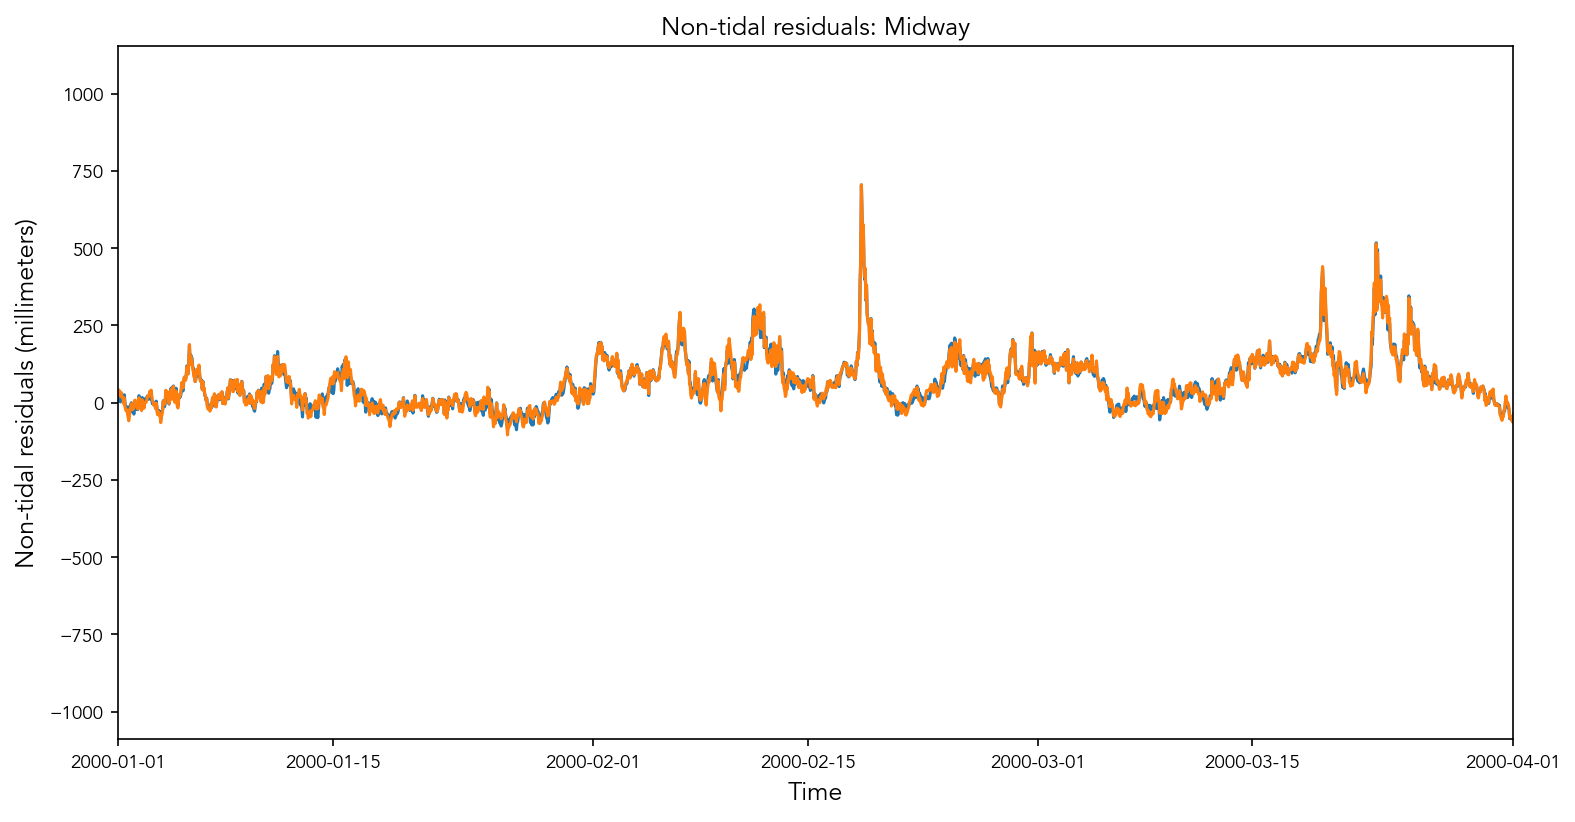

In [666]:
#plot time series
plt.figure(figsize=(12, 6))
plt.plot(ntr_data['time'], ntr_data['ntr'], label='NTR')
plt.plot(ntr_data['time'], ntr_data['ntr_withNodal'], label='Nodal Cycle')
# add title
plt.title('Non-tidal residuals: ' + station_name)
plt.xlabel('Time')
plt.ylabel('Non-tidal residuals' + ' (' + ds['sea_level'].attrs['units'] + ')')

#set x-axis to 2000-2005
plt.xlim([np.datetime64('2000-01-01'), np.datetime64('2000-04-01')])

In [667]:
Annualfreq_cpd = 1/365.25
SemiAnnualfreq_cpd = 1/182.625
QtrAnnualfreq_cpd = 1/91.3125
highFreq_cpd = 1/7 # anything higher than a week
trimonthlyFreq_cpd = 1/90

In [668]:
#detrend the ntr and fill with zeros

def process_trend_with_nan(sea_level_data, time_column='time', weighted=False):
    """
    Compute trends for sea level anomaly data, handling NaNs.
    
    Supports both pandas.DataFrame and xarray.DataArray.
    
    Parameters:
    - sea_level_data: pandas.DataFrame or xarray.DataArray
    - time_column: str, column name for time in a DataFrame (ignored for xarray)
    - weighted: bool, whether to apply cosine weighting (only applies to gridded xarray data)

    Returns:
    - trend_mag: Trend magnitude over time
    - sea_level_trend: Trend values
    - trend_rate: Rate of change per year
    """
    import xarray as xr

    # Handle xarray input
    if isinstance(sea_level_data, xr.DataArray):
        sea_level_data = sea_level_data.transpose('time', ...) if 'time' in sea_level_data.dims else sea_level_data
        time_index = pd.to_datetime(sea_level_data.time.values).to_julian_date()

        # If it's a single time series
        if sea_level_data.ndim == 1:
            y = sea_level_data.values
            mask = ~np.isnan(y)

            if np.any(mask):
                time_masked = time_index[mask]
                y_masked = y[mask]

                slope, intercept, _, _, _ = stats.linregress(time_masked, y_masked)
                trend = slope * time_index + intercept
                detrended = y - trend

                trend_mag = trend[-1] - trend[0]
                time_mag = (pd.to_datetime(sea_level_data.time.values[-1]) - pd.to_datetime(sea_level_data.time.values[0])).days / 365.25
                trend_rate = trend_mag / time_mag

                return trend_mag, trend, trend_rate
            else:
                return np.nan, np.nan, np.nan

        # For multidimensional xarray data
        sla_flat = sea_level_data.values.reshape(sea_level_data.shape[0], -1)
        detrended_flat = np.full_like(sla_flat, fill_value=np.nan)

        for i in range(sla_flat.shape[1]):
            y = sla_flat[:, i]
            mask = ~np.isnan(y)

            if np.any(mask):
                time_masked = time_index[mask]
                y_masked = y[mask]

                slope, intercept, _, _, _ = stats.linregress(time_masked, y_masked)
                trend = slope * time_index + intercept

                detrended_flat[:, i] = y - trend

        detrended = detrended_flat.reshape(sea_level_data.shape)
        sea_level_trend = sea_level_data - detrended
        trend_mag = sea_level_trend[-1] - sea_level_trend[0]

        times = pd.to_datetime(sea_level_data['time'].values)
        time_mag = (times[-1] - times[0]).days / 365.25
        trend_rate = trend_mag / time_mag

        if weighted:
            if 'latitude' in sea_level_data.dims:
                weights = np.cos(np.deg2rad(sea_level_data.latitude))
                weights.name = 'weights'

                trend_mag = (trend_mag * weights).mean()
                trend_rate = (trend_rate * weights).mean()
                sea_level_trend = (sea_level_trend * weights).mean(dim=['latitude', 'longitude'])
            else:
                raise ValueError("Weighted trend calculation requires latitude coordinate.")

        return trend_mag, sea_level_trend, trend_rate

    # Handle DataFrame input
    elif isinstance(sea_level_data, pd.DataFrame):
        if time_column not in sea_level_data.columns:
            raise ValueError(f"Time column '{time_column}' not found in DataFrame.")

        # Convert time to Julian date
        time_index = pd.to_datetime(sea_level_data[time_column]).map(lambda x: x.toordinal() + 1721424.5)



        # Exclude the time column from analysis
        data_columns = [col for col in sea_level_data.columns if col != time_column]
        
        trend_magnitudes = {}
        trend_series = {}
        trend_rates = {}

        for col in data_columns:
            y = sea_level_data[col].values
            mask = ~np.isnan(y)

            if np.any(mask):
                time_masked = time_index[mask]
                y_masked = y[mask]

                slope, intercept, _, _, _ = stats.linregress(time_masked, y_masked)
                trend = np.array(slope * time_index + intercept)
                detrended = y - trend

                
                if len(trend) > 1:
                    trend_mag = trend[-1] - trend[0]
                    time_mag = (pd.to_datetime(sea_level_data[time_column].iloc[-1]) - pd.to_datetime(sea_level_data[time_column].iloc[0])).days / 365.25
                    trend_rate = trend_mag / time_mag
                else:
                    trend_mag = np.nan
                    trend_rate = np.nan

                trend_magnitudes[col] = trend_mag
                trend_series[col] = trend
                trend_rates[col] = trend_rate
            else:
                trend_magnitudes[col] = np.nan
                trend_series[col] = np.nan
                trend_rates[col] = np.nan

        return trend_magnitudes, trend_series, trend_rates

    else:
        raise TypeError("Input must be an xarray.DataArray or pandas.DataFrame.")



ntr_data_mags,ntr_trend_series,ntr_trend_rates = process_trend_with_nan(ntr_data)


Text(0, 0.5, 'Non-tidal residuals (millimeters)')

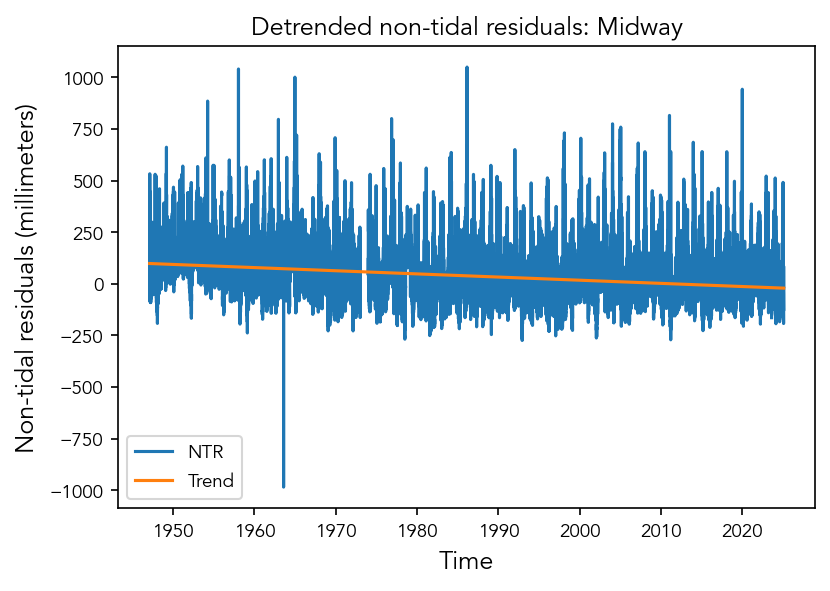

In [669]:
plt.plot(ntr_data['time'], ntr_data['ntr'], label='NTR')
plt.plot(ntr_data['time'], ntr_trend_series['ntr'], label='Trend')
plt.legend()

# add title
plt.title('Detrended non-tidal residuals: ' + station_name)
plt.xlabel('Time')
plt.ylabel('Non-tidal residuals' + ' (' + ds['sea_level'].attrs['units'] + ')')

In [670]:
ntr_data['ntr_detrended'] = ntr_data['ntr'] - ntr_trend_series['ntr']
ntr_data

,time,ntr,sea_level,tide,nodal,ntr_withNodal,ntr_detrended
0,1947-02-08 04:00:00,219.991209,1189.0,969.008791,-12.397006,207.594203,121.579348
1,1947-02-08 05:00:00,255.132164,1250.0,994.867836,-16.478207,238.653958,156.720304
2,1947-02-08 06:00:00,267.260455,1250.0,982.739545,-18.188605,249.071850,168.848594
3,1947-02-08 07:00:00,284.731082,1219.0,934.268918,-18.475715,266.255367,186.319221
4,1947-02-08 08:00:00,293.956199,1158.0,864.043801,-18.088657,275.867542,195.544339
...,...,...,...,...,...,...,...
683583,2025-01-31 19:00:00,22.369370,1317.0,1294.630630,8.408938,30.778308,43.203854
683584,2025-01-31 20:00:00,10.499296,1240.0,1229.500704,11.343860,21.843156,31.333780
683585,2025-01-31 21:00:00,6.865975,1159.0,1152.134025,12.839269,19.705243,27.700459
683586,2025-01-31 22:00:00,-1.348111,1080.0,1081.348111,12.557502,11.209391,19.486374


In [671]:
#replace all nans with zeros and plot
# ntr_data['ntr_detrended'] = ntr_data['ntr_detrended'].fillna(0)

#if there are time 

# plt.plot(ntr_data['time'], ntr_data['ntr_detrended'], label='NTR Detrended')

In [672]:
# Now start to filter for each frequency band we want

# make time_diffs in hours
time_diffs = np.diff(ntr_data['time']).astype('timedelta64[h]').astype(int)

# Remove the lowest frequencies first (decadal and multi-year)
# Filter out Nodal Component
# widthNodal = 1/(365.25*18.61*10) #18.61 years
# ntr_noNodal, ntr_nodal = filter_known_frequency_components(ntr_data['ntr_detrended'], time_diffs, 1/(365.25*18.61), width=widthNodal)
# ntr_nodal = np.zeros(len(ntr_data['ntr_detrended']))
# ntr_noNodal = ntr_data['ntr_detrended']
# Filter out annual, semi-annual, and quarter-annual components
widthSeasonal = 1/365.25/10; #1 cycle per decade
# segments = segment_by_nan_runs(ntr_data[['ntr_detrended', 'time']],value_column='ntr_detrended',max_nan_run=24*7*8)
# segments


In [673]:
# # print the length of each segment and the start and end times
# for i in range(len(segments)):
#     print(f'Segment {i}: {len(segments[i])} points, {segments[i].time.iloc[0]} to {segments[i].time.iloc[-1]}')

In [674]:
# filtered_segments = filter_segments(segments,value_column='ntr_detrended',freq_cutoff=1/(365.25*20),order=4)

```{caution}
Will need to adjust period for mesoscale processes. Higher the latitude the longer the period!!
```
From Chen, S., and B. Qiu (2010), Mesoscale eddies northeast of the Hawaiian archipelago from satellite altimeter observations, J. Geophys. Res., 115, C03016, doi:10.1029/2009JC005698


"We define dominant periods of the mesoscale eddy activity by locating the periods at which the spectral peaks within the mesoscale range of 90–180 days. This definition is crude yet robust for the subregions with sharp spectral peaks like the 24°N–27°N, 160°W–155°W one (130 days) and the 18°N–21°N, 170°W–165°W one (90 days), but is also applicable to other subregions. In the lee of the island of Hawaii, 90 day oscillations dominate the mesoscale eddy activity. In the subregions between 24°N and 30°N, a 130 day peak often prevails, but in the 30°N–33°N band, a weak 180 day peak emerges. The pattern is that the higher the latitude, the longer the dominant period."

In [696]:

ntr_noAnnual, ntr_Annual = filter_known_frequency_components(ntr_data['ntr_detrended'], time_diffs, Annualfreq_cpd, width=widthSeasonal)
ntr_noSemiAnnual, ntr_SemiAnnual = filter_known_frequency_components(ntr_noAnnual, time_diffs, SemiAnnualfreq_cpd, width=widthSeasonal)
ntr_noQtrAnnual, ntr_QtrAnnual = filter_known_frequency_components(ntr_noSemiAnnual, time_diffs, QtrAnnualfreq_cpd, width=widthSeasonal)
ntr_Seasonal = ntr_Annual + ntr_SemiAnnual + ntr_QtrAnnual

#>20 years
ntr_lowFreq, ntr_highFreq = butterworth_lowpass(ntr_noQtrAnnual, time_diffs, 1/(365.25*20), order=3, padtype='even', padlen=3)
# ntr_lowFreq, ntr_highFreq = butterworth_lowpass(ntr_noQtrAnnual, time_diffs, 1/(365.25*20), order=3)

#10-20 years
ntr_decadal, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/(365.25*10), order=3) 

#1-10 years
ntr_multiyear, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, 1/(365.25*1), order=4)



# 3 month-1 year
ntr_subAnnual, ntr_highFreq = butterworth_lowpass(ntr_highFreq, time_diffs, trimonthlyFreq_cpd, order=5)

# Remove high frequencies (weekly to hourly)
# ntr_weekly is timescales longer than 7 days but less than 1 month
ntr_Weekly, ntr_subWeekly = butterworth_lowpass(ntr_highFreq, time_diffs, highFreq_cpd, order=5)



Filled 5 % of data with noise (std = 92.3913).
Filled 5 % of data with noise (std = 90.1763).
Filled 5 % of data with noise (std = 89.0544).
Filled 5 % of data with noise (std = 88.5581).


In [676]:
# make dataframe of filtered data
ntr_filtered = pd.DataFrame({'time': ntr_data['time'], 
                             'ntr': ntr_data['ntr_detrended'], 
                             'sea_level': ntr_data['sea_level'],
                             'tide': ntr_data['tide'],
                             'Nodal': ntr_data['nodal'],
                             '20+ years': ntr_lowFreq, 
                             '10-20 year': ntr_decadal, 
                             '1-10 year': ntr_multiyear, 
                             'Seasonal': ntr_Seasonal, 
                             '3 month - 1 year': ntr_subAnnual, 
                             '1 week - 3 month': ntr_Weekly, 
                             '< 1 week': ntr_subWeekly})
ntr_filtered

# get std of each component
ntr_component_stds = ntr_filtered.std()

# remove time from ntr)component_stds
ntr_component_stds = ntr_component_stds.drop('time')

# make a dictionary of the timeframes and the processes
timeframes = {'20+ years': 'PDO', 
              '10-20 year': 'Decadal', 
              '1-10 year': 'ENSO', 
              'Seasonal': 'Annual, Semi-Annual, Qtr-Annual', 
              '3 month - 1 year': 'SubAnnual', 
              '1 week - 3 month': 'Mesoscale eddies', 
              '< 1 week': 'Storms & Short-term variability'}

In [677]:
ntr_component_stds

ntr                    92.3914
sea_level           152.464508
tide                136.468595
Nodal                11.228485
20+ years            24.380344
10-20 year            8.139834
1-10 year            36.124458
Seasonal             19.726626
3 month - 1 year     38.440532
1 week - 3 month     47.540464
< 1 week             40.539058
dtype: object

Text(0, 0.5, 'Sum of components')

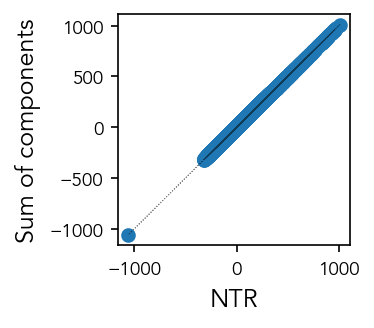

In [678]:
#plot ntr, then plot summed components
plt.figure(figsize=(2, 2))
ntr_sum = (ntr_filtered['20+ years']+
         ntr_filtered['10-20 year']+
         ntr_filtered['1-10 year']+
         ntr_filtered['Seasonal']+
         ntr_filtered['3 month - 1 year']+
         ntr_filtered['1 week - 3 month']+
         ntr_filtered['< 1 week'])
#make a dotted 1:1 line
plt.plot(ntr_filtered['ntr'], ntr_filtered['ntr'], 'k:', label='1:1 line',linewidth=0.5,alpha=0.5)
plt.scatter(ntr_filtered['ntr'], ntr_sum)

plt.xlabel('NTR')
plt.ylabel('Sum of components')


In [679]:
#export data
# ntr_filtered.to_csv('data/ntr_filtered_059b.csv', index=False)

Text(0.5, 1.0, 'Correlation between each component')

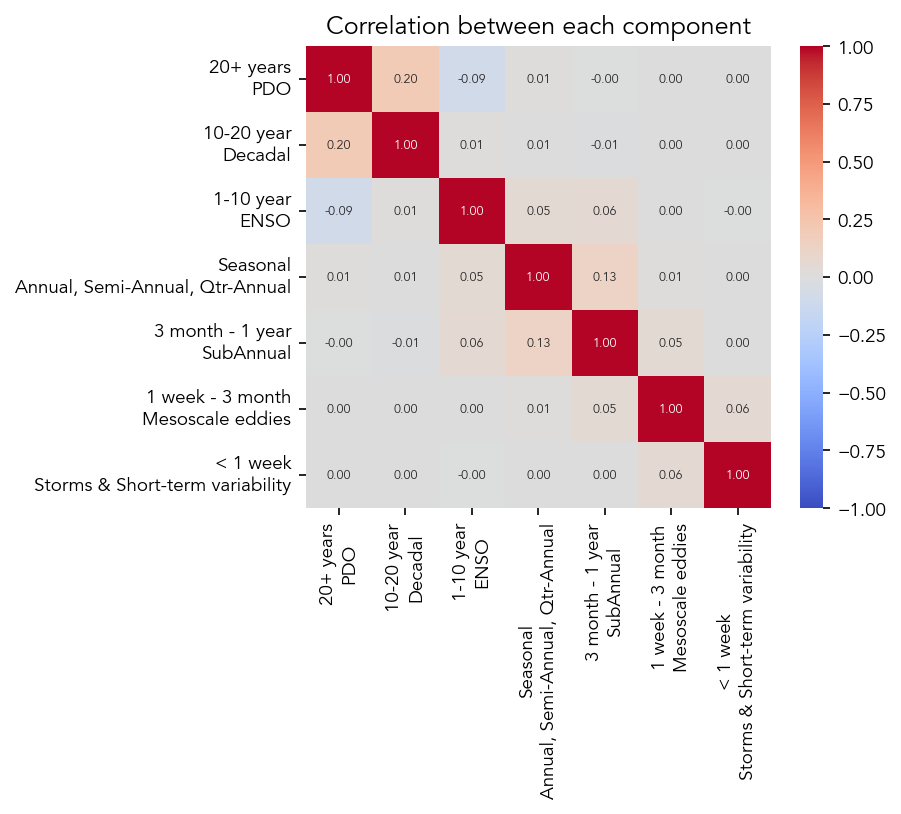

In [680]:
import seaborn as sns
import matplotlib.pyplot as plt

#make a heatmap plot of correlation between each component
ntr_corr = ntr_filtered.drop(['time','sea_level','tide','Nodal','ntr'], axis=1).corr()

# add description to each component in ntr correlation matrix
ntr_corr.columns = [col + '\n' + timeframes[col] for col in ntr_corr.columns]
ntr_corr.index = [col + '\n' + timeframes[col] for col in ntr_corr.index]
#exclude time,sea_level, and tide from the correlation matrix

#plot heatmap
plt.figure(figsize=(5,4))
sns.heatmap(ntr_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", annot_kws={"size": 6})
plt.title('Correlation between each component')



Note there is correlation between some of these timeseries, likely due to the filtering process employed in this notebook. 

In [681]:
# get cumulative sums of Nodal, > 20 years, 10-20 years, 1-10 years, Seasonal, 1 month - 1 year, 1 week - 1 month, and < 1 week columns
# do the cumsum of ntr_filtered columns Nodal, > 20 years, 10-20 year, 1-10 year, Seasonal, 1 month - 1 year, 1 week - 1 month, and < 1 week by column (horizontal)
ntr_cumsum = ntr_filtered[['20+ years', '10-20 year', '1-10 year', 'Seasonal', '3 month - 1 year', '1 week - 3 month', '< 1 week']].cumsum(axis=1)
ntr_cumsum_stds = ntr_cumsum.std()
ntr_cumsum_stds
# make a plot of ntr_filtered and ntr_cumsum
# fig, ax = plt.subplots(figsize=(12, 6))
# ntr_filtered.plot(x='time', y=['ntr'], ax=ax, color=['black'], linewidth=1)
# ntr_filtered_sums.plot(x='time', y=['Nodal'] +['> 20 years'], ax=ax, color='yellow',linewidth=1, linestyle='--')
# ntr_cumsum.plot(x='time', y=['Nodal', '> 20 years'], ax=ax, linewidth=1, linestyle='--')
# ntr_cumsum.plot(x='time', y=['Nodal', '> 20 years', '10-20 year', '1-10 year', 'Seasonal', '1 month - 1 year', '1 week - 1 month', '< 1 week'], ax=ax, linewidth=1, linestyle='--')


20+ years           24.380344
10-20 year          27.177343
1-10 year           43.458618
Seasonal            49.213874
3 month - 1 year    64.509613
1 week - 3 month    81.466052
< 1 week            92.166467
dtype: float64

In [682]:
ntr_filtered

,time,ntr,sea_level,tide,Nodal,20+ years,10-20 year,1-10 year,Seasonal,3 month - 1 year,1 week - 3 month,< 1 week
0,1947-02-08 04:00:00,121.579348,1189.0,969.008791,-12.397006,60.813555,37.715311,-16.561835,-10.436297,7.502578,14.740136,27.805901
1,1947-02-08 05:00:00,156.720304,1250.0,994.867836,-16.478207,60.813008,37.712201,-16.586592,-10.432500,7.450451,13.736728,64.027007
2,1947-02-08 06:00:00,168.848594,1250.0,982.739545,-18.188605,60.812462,37.709092,-16.611348,-10.428639,7.398190,12.702891,77.265946
3,1947-02-08 07:00:00,186.319221,1219.0,934.268918,-18.475715,60.811916,37.705982,-16.636103,-10.424715,7.345796,11.639331,95.877014
4,1947-02-08 08:00:00,195.544339,1158.0,864.043801,-18.088657,60.811369,37.702873,-16.660858,-10.420727,7.293268,10.546801,106.271613
...,...,...,...,...,...,...,...,...,...,...,...,...
683583,2025-01-31 19:00:00,43.203854,1317.0,1294.630630,8.408938,24.377753,2.363339,-45.349306,-10.454324,57.108719,-23.409844,38.567516
683584,2025-01-31 20:00:00,31.333780,1240.0,1229.500704,11.343860,24.377753,2.363339,-45.349306,-10.450847,57.108719,-23.405302,26.689424
683585,2025-01-31 21:00:00,27.700459,1159.0,1152.134025,12.839269,24.377753,2.363339,-45.349306,-10.447306,57.108719,-23.401640,23.048900
683586,2025-01-31 22:00:00,19.486374,1080.0,1081.348111,12.557502,24.377753,2.363339,-45.349306,-10.443701,57.108719,-23.398723,14.828292


/Users/juliafiedler/anaconda3/envs/SLI39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


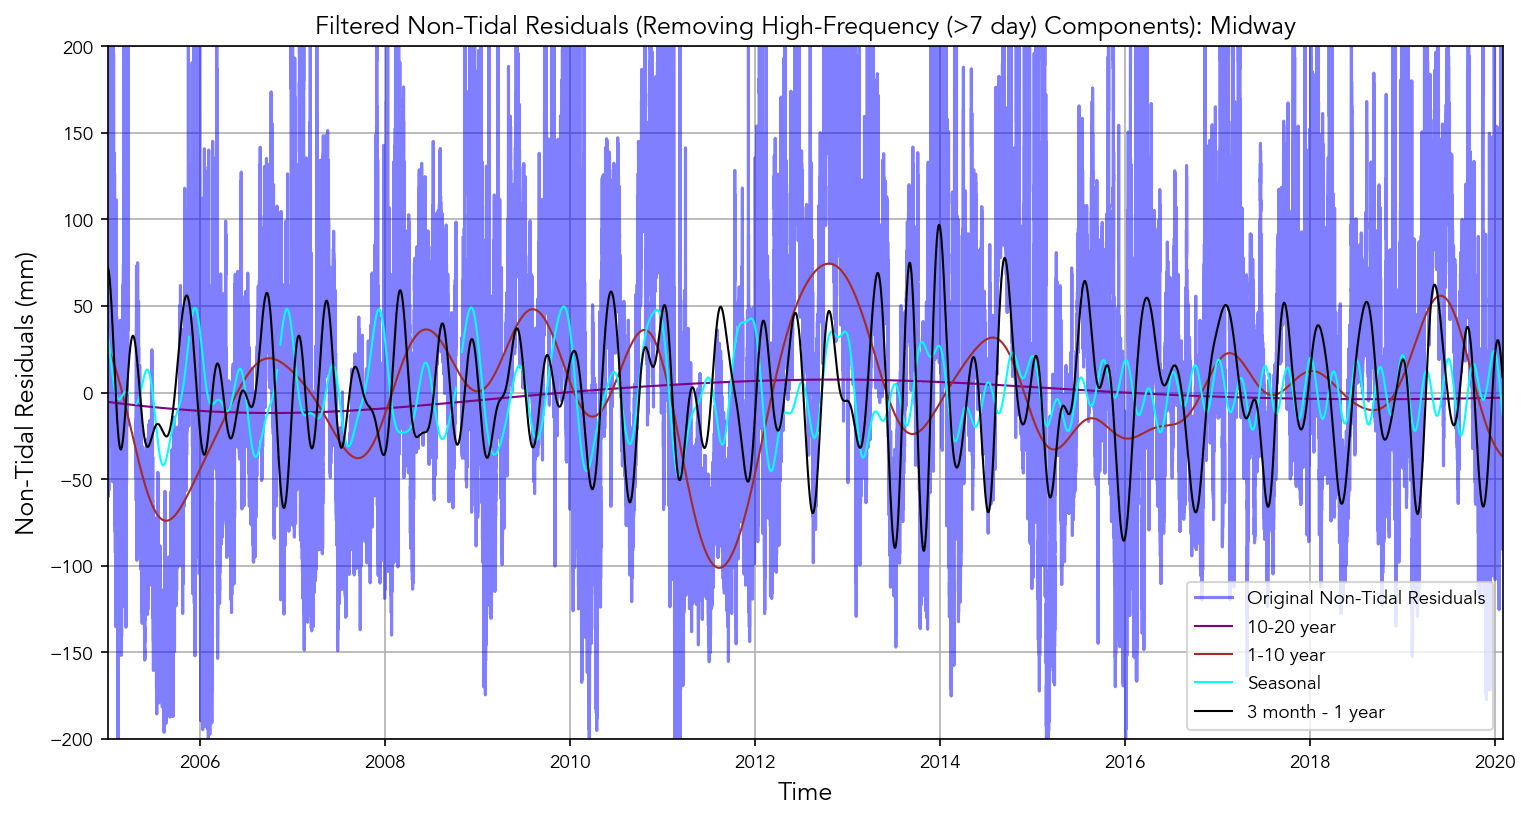

In [683]:
# Plot original vs. filtered signal
plt.figure(figsize=(12, 6))
plt.plot(ntr_filtered['time'], ntr_filtered['ntr'], label='Original Non-Tidal Residuals', color ="blue",alpha=0.5)
# plt.plot(ntr_filtered['time'], ntr_filtered['> 20 years'], label='$NTR - NTR_{hf}$', color='orange', linewidth=2)

# ntr_summed = ntr_Annual + ntr_SemiAnnual + ntr_QtrAnnual + ntr_subAnnual + ntr_multiyear + ntr_decadal + ntr_lowFreq + ntr_monthly
# ntr_summed = ntr_filtered['Nodal']+ ntr_filtered['> 20 years'] + ntr_filtered['10-20 year'] + ntr_filtered['1-10 year'] + ntr_filtered['Seasonal'] + ntr_filtered['1 month - 1 year'] + ntr_filtered['1 week - 1 month'] + ntr_filtered['< 1 week']

# plt.plot(ntr_filtered['time'], ntr_summed, label='Sum of Filtered Components', color='red', linewidth=1)

# plt.plot(ntr_filtered['time'], ntr_filtered['Nodal']+ntr_filtered['nodal_utide'], label='Nodal', color='green', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['> 20 years'], label='> 20 years', color='orange', linewidth=1)
plt.plot(ntr_filtered['time'], ntr_filtered['10-20 year'], label='10-20 year', color='purple', linewidth=1)
plt.plot(ntr_filtered['time'], ntr_filtered['1-10 year'], label='1-10 year', color='brown', linewidth=1)
plt.plot(ntr_filtered['time'], ntr_filtered['Seasonal'], label='Seasonal', color='cyan', linewidth=1)
plt.plot(ntr_filtered['time'], ntr_filtered['3 month - 1 year'], label='3 month - 1 year', color='black', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['1 week - 2 month'], label='1 week - 2 month', color='pink', linewidth=1)
# plt.plot(ntr_filtered['time'], ntr_filtered['< 1 week'], label='< 1 week', color='grey', linewidth=1)

plt.xlabel('Time')
plt.ylabel('Non-Tidal Residuals (mm)')
plt.title('Filtered Non-Tidal Residuals (Removing High-Frequency (>7 day) Components): ' + station_name)
plt.legend()
plt.grid()

# change xlim to zoom in
plt.xlim(pd.Timestamp('2005-01-01'), pd.Timestamp('2020-02-01'))
plt.ylim(-200, 200)
plt.show()

In [684]:
ntr_component_stds

ntr                    92.3914
sea_level           152.464508
tide                136.468595
Nodal                11.228485
20+ years            24.380344
10-20 year            8.139834
1-10 year            36.124458
Seasonal             19.726626
3 month - 1 year     38.440532
1 week - 3 month     47.540464
< 1 week             40.539058
dtype: object

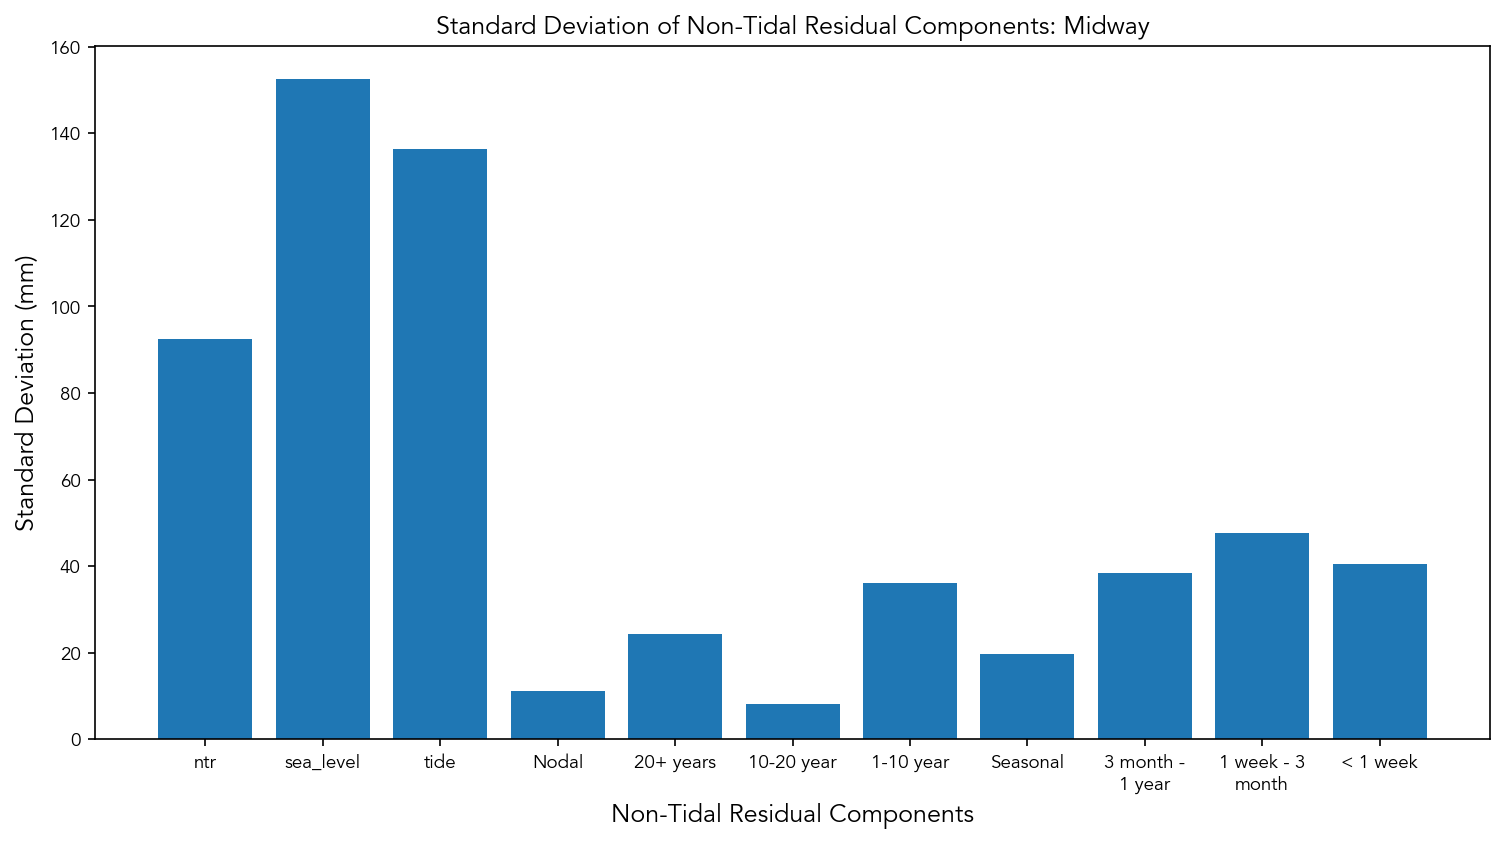

In [685]:
#make a bar plot of the std of each component
import textwrap

fig, ax = plt.subplots(figsize=(12, 6))
component_names = ntr_component_stds.index
component_stds = ntr_component_stds
ax.bar(component_names, component_stds)
wrapped_labels = ['\n'.join(textwrap.wrap(label, width=10)) for label in component_names]
plt.xticks(range(len(component_names)), wrapped_labels)
# plt.xticks(rotation=45)
ax.set_xlabel('Non-Tidal Residual Components')
ax.set_ylabel('Standard Deviation (mm)')
ax.set_title('Standard Deviation of Non-Tidal Residual Components: ' + station_name)


plt.show()

In [686]:
component_stds

ntr                    92.3914
sea_level           152.464508
tide                136.468595
Nodal                11.228485
20+ years            24.380344
10-20 year            8.139834
1-10 year            36.124458
Seasonal             19.726626
3 month - 1 year     38.440532
1 week - 3 month     47.540464
< 1 week             40.539058
dtype: object

## Plot components
Make a bar plot of average contributions to water levels.

/var/folders/9w/vpws17h965v7n60fmhp97k5r0000gq/T/ipykernel_30355/3394451137.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.bar('Components', 0.4*ntr_cumsum_stds[i], bottom=0, label=ntr_cumsum_stds.index[i].replace('\n', ' '))


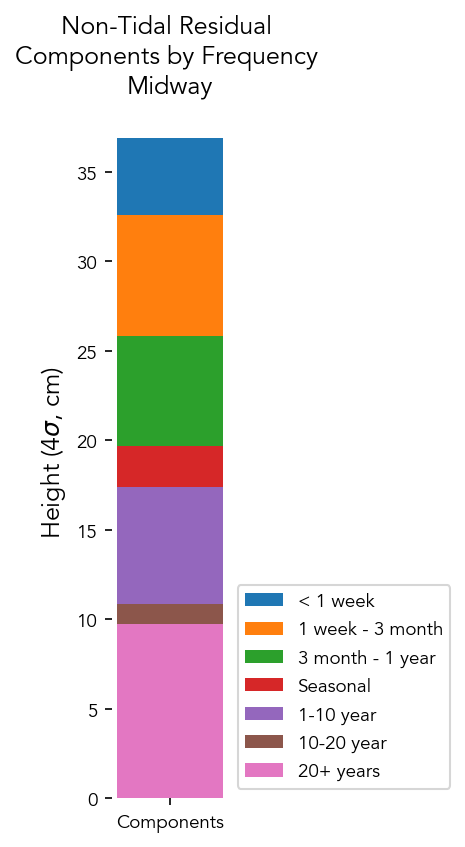

In [687]:
# Create figure
fig, ax = plt.subplots(figsize=(1, 6))

# Plot stacked bars
bottom = 0
for i in range(len(ntr_cumsum_stds.index)-1, -1, -1):
    ax.bar('Components', 0.4*ntr_cumsum_stds[i], bottom=0, label=ntr_cumsum_stds.index[i].replace('\n', ' '))

# ax.bar('Total NTR', np.std(ntr_filled), color='white', edgecolor='black', linewidth=1)

# Labels and title
ax.set_ylabel('Height (4$\sigma$, cm)')
ax.set_title('Non-Tidal Residual \nComponents by Frequency \n' + station_name)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0))
# plt.xticks(rotation=45)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# no box
for spine in ax.spines.values():
    spine.set_visible(False)

figName = 'NTR_components_stds' + station_name
glue('NTR_components_stds',fig,display=False)


It's important to note that in the plot above, we're looking at the $4\sigma$, which is akin to 'significant wave height.' Nor do we consider each $\sigma$ independently in this plot, but instead we compute the standard deviation of the combined signals, as we work our way up to higher and higher frequencies. For example, the purple line above shows the contributions of any cycles that occur on timescales longer than 1 year. Each individual componenent has its own standard deviation but none are truly indepedent signals (due to the filtering mechanism here) and therefore the variances cannot be added together to represent the total variances of the whole signal.

In [691]:
# get dates of extreme events
station_name_1st = station_name.split(',')[0]
top10tableName = 'SL_top_10_table_' + station_name_1st + '.csv'
output_dir = Path('../output')
extremes_csv = Path(output_dir, top10tableName)
extremes = pd.read_csv(extremes_csv)

In [593]:
extremes

,Rank,Highest,Highest Date,Highest ONI Mode,Lowest,Lowest Date,Lowest ONI Mode,Zone,ONI max,ONI min
0,1,0.496,2015-09-17 15:00,El Nino,-2.016,2011-03-11 15:00,La Nina,GMT,2.42,-0.93
1,2,0.477,1994-10-04 23:00,Neutral,-1.024,2010-02-28 03:00,El Nino,GMT,0.74,0.84
2,3,0.474,1995-11-24 14:00,La Nina,-0.952,2011-12-25 06:00,La Nina,GMT,-0.98,-0.86
3,4,0.461,2020-12-15 14:00,La Nina,-0.943,1998-06-24 18:00,Neutral,GMT,-1.19,-0.78
4,5,0.458,2017-08-21 00:00,Neutral,-0.933,1999-01-02 06:00,La Nina,GMT,-0.38,-1.55
5,6,0.453,2021-12-05 14:00,Neutral,-0.923,2001-06-24 21:00,Neutral,GMT,-0.98,-0.08
6,7,0.443,2019-12-26 13:00,Neutral,-0.921,2009-05-25 19:00,Neutral,GMT,0.50,0.28
7,8,0.436,2023-08-02 01:00,Neutral,-0.911,2009-06-23 18:00,Neutral,GMT,1.32,0.45
8,9,0.433,2020-07-21 01:00,Neutral,-0.910,2009-01-10 05:00,Neutral,GMT,-0.57,-0.85
9,10,0.432,2020-07-06 02:00,Neutral,-0.903,2010-01-01 07:00,El Nino,GMT,-0.41,1.50


In [692]:
extremes_highest = extremes['Highest Date'].values
extremes_lowest = extremes['Lowest Date'].values

extremes_highest = pd.to_datetime(extremes_highest)
extremes_lowest = pd.to_datetime(extremes_lowest)

extremes_highest

DatetimeIndex(['2011-01-14 20:00:00', '2019-12-29 19:00:00',
               '2005-01-16 07:00:00', '1998-02-12 19:00:00',
               '2018-02-01 18:00:00', '2013-12-18 20:00:00',
               '2004-01-11 19:00:00', '2015-01-20 15:00:00',
               '2000-02-18 15:00:00', '2003-01-24 08:00:00'],
              dtype='datetime64[ns]', freq=None)

In [693]:
# extract these dates from the ntr filtered data
ntr_filtered_extremes_high = ntr_filtered[ntr_filtered['time'].isin(extremes_highest)].copy()
ntr_filtered_extremes_low = ntr_filtered[ntr_filtered['time'].isin(extremes_lowest)].copy()

# get tide data for these dates from ntr_data
tide_data = ntr_data['tide']
ntr_data_extremes_high = ntr_data[ntr_data['time'].isin(extremes_highest)].copy()
ntr_data_extremes_low = ntr_data[ntr_data['time'].isin(extremes_lowest)].copy()

# add tide and sea level data to ntr_filtered_extremes_high
ntr_filtered_extremes_high.loc[:, 'tide'] = ntr_data_extremes_high['tide'].values
ntr_filtered_extremes_high.loc[:, 'sea_level'] = ntr_data_extremes_high['sea_level'].values
ntr_filtered_extremes_low.loc[:, 'tide'] = ntr_data_extremes_low['tide'].values
ntr_filtered_extremes_low.loc[:, 'sea_level'] = ntr_data_extremes_low['sea_level'].values


# arrange columns
ntr_filtered_extremes_high = ntr_filtered_extremes_high[['time', 'ntr', 'sea_level', 'tide', 'Nodal','Seasonal','< 1 week', '1 week - 3 month', '3 month - 1 year', '1-10 year', '10-20 year', '20+ years']]
ntr_filtered_extremes_low = ntr_filtered_extremes_low[['time', 'ntr', 'sea_level', 'tide', 'Nodal','Seasonal','< 1 week', '1 week - 3 month', '3 month - 1 year', '1-10 year', '10-20 year', '20+ years']]

ntr_filtered_extremes_high

#export data
ntr_filtered_extremes_high.to_csv('../data/ntr_filtered_extremes_high_059b.csv', index=False)
ntr_filtered_extremes_low.to_csv('../data/ntr_filtered_extremes_low_059b.csv', index=False)


In [694]:
ntr_filtered_extremes_high

,time,ntr,sea_level,tide,Nodal,Seasonal,< 1 week,1 week - 3 month,3 month - 1 year,1-10 year,10-20 year,20+ years
447183,1998-02-12 19:00:00,710.816785,1884.0,1152.778443,-0.212692,21.691386,379.153392,179.805743,125.925455,24.630974,-4.536340,-15.853824
464843,2000-02-18 15:00:00,549.613060,1826.0,1259.063599,8.949944,7.578417,422.224790,61.159216,14.191113,42.636267,10.701563,-8.878305
490540,2003-01-24 08:00:00,611.643943,1818.0,1193.516700,-15.644105,-5.236459,396.755240,94.742513,81.954491,33.894719,9.381622,0.151816
498999,2004-01-11 19:00:00,576.477619,1853.0,1265.156752,12.049090,16.737485,245.388123,204.770371,100.925827,3.927301,2.113394,2.615117
507891,2005-01-16 07:00:00,749.261086,1924.0,1164.926560,-8.196638,15.422307,322.635161,340.070413,50.921186,20.837821,-5.644223,5.018421
560440,2011-01-14 20:00:00,807.392849,1951.0,1142.959542,1.966056,22.648138,541.748904,162.166099,48.795063,9.665126,4.281797,18.087723
586096,2013-12-18 20:00:00,689.554688,1859.0,1173.273313,-16.699959,25.751528,337.750294,221.170950,85.709681,-9.272076,6.197257,22.247055
595643,2015-01-20 15:00:00,527.641091,1831.0,1308.853227,-3.607441,11.724377,212.637987,278.588259,19.802736,-21.240872,3.012764,23.115839
622238,2018-02-01 18:00:00,587.311556,1879.0,1301.821655,9.667739,-3.060865,201.748540,317.495459,38.832405,11.773855,-3.631362,24.153524
638943,2019-12-29 19:00:00,619.592454,1936.0,1329.454718,9.901046,24.158687,314.372253,273.410824,16.169464,-29.761590,-3.049444,24.292260


(17463.75, 17663.75)

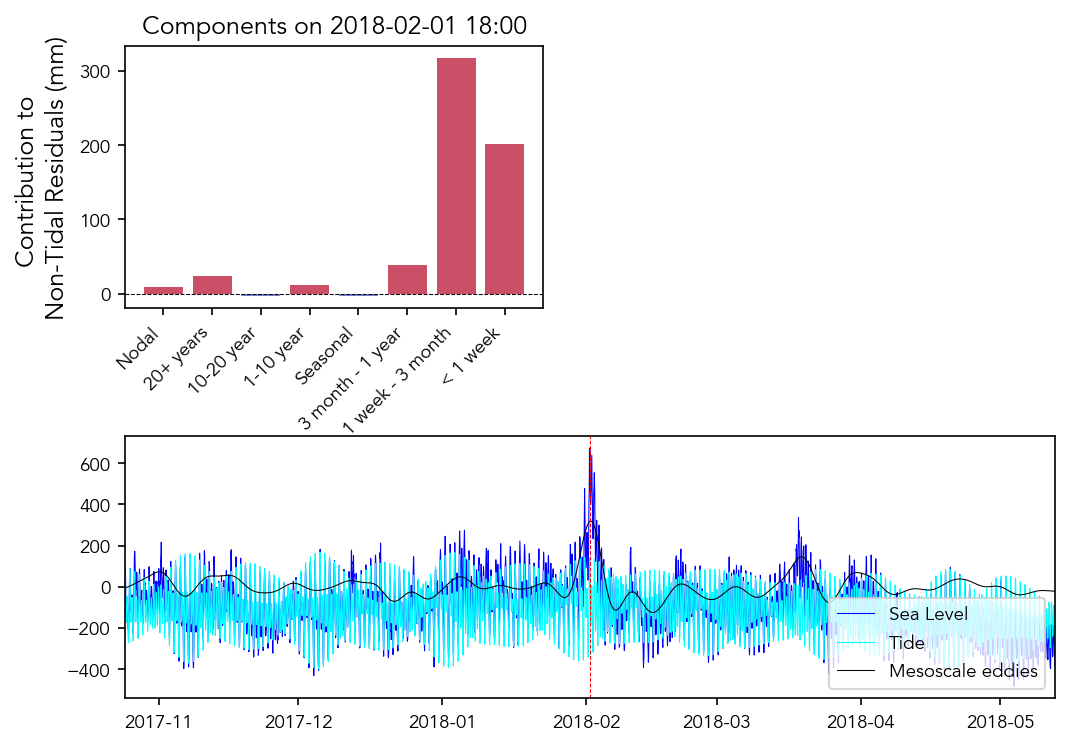

In [695]:
# Filter the data for the specific dates
# dates_to_plot = extremes_highest[1]
# get data on the date of the highest sea level
dates_to_plot = ntr_filtered_extremes_high['time'].values[8]
date_str = pd.to_datetime(dates_to_plot).strftime('%Y-%m-%d %H:%M')
data_on_date = ntr_filtered_extremes_high[ntr_filtered_extremes_high['time'] == dates_to_plot]

# Extract the components
components = ['Nodal', '20+ years', '10-20 year', '1-10 year', 'Seasonal', '3 month - 1 year', '1 week - 3 month', '< 1 week']

component_values = data_on_date[components].values.flatten()
x_positions = np.arange(len(components))  # Positions for each component

fig,axes = plt.subplots(2,1,figsize=(8, 5))
# Normalize the component values to get colors
norm = plt.Normalize(vmin=-3, vmax=3)
cmap = plt.cm.coolwarm
colors = cmap(norm(component_values))
ax = axes[0]
ax.bar(x_positions, component_values, alpha=0.7, color=colors)
ax.set_xticks(x_positions)
ax.set_xticklabels(components, rotation=45, ha='right')

# add title and labels
ax.set_title('Components on ' + date_str)
ax.set_ylabel('Contribution to \nNon-Tidal Residuals (mm)')
ax.set_xticks(x_positions)

# add dotted line at 0
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)

#change axes[0] width to be 0.75 of the original width
box = ax.get_position()
ax.set_position([box.x0, box.y0+0.1, box.width * 0.45, box.height])

ax = axes[1]
#plot tide, sea level, and ntr on the same plot
plusTime = pd.Timedelta('100d')
timespan = pd.date_range(start=dates_to_plot - plusTime, end=dates_to_plot + plusTime, freq='h')
data_on_date = ntr_filtered[ntr_filtered['time'].isin(timespan)]

# data_on_date['time'] = pd.to_datetime(data_on_date['time'])
data_on_date.set_index('time', inplace=True)
#plot sea level and tide

ax.plot(data_on_date['sea_level']-mhhw, label='Sea Level', color='blue',linewidth=0.5)
ax.plot(data_on_date['tide']-mhhw, label='Tide', color='cyan',linewidth=0.5)
ax.plot(data_on_date['1 week - 3 month'], label='Mesoscale eddies', color='black',linewidth=0.5)
ax.legend(loc='lower right')
# add vertical line at the date
ax.axvline(dates_to_plot, color='red', linestyle='--', linewidth=0.5)

ax.set_xlim([timespan[0], timespan[-1]])



In [604]:
ntr_filtered

,time,ntr,sea_level,tide,Nodal,20+ years,10-20 year,1-10 year,Seasonal,3 month - 1 year,1 week - 3 month,< 1 week
0,1950-10-19 02:00:00,42.274923,1006.0,1001.760365,24.859658,-3.389390,56.535515,-14.895483,7.539434,-20.202205,13.525478,3.161573
1,1950-10-19 03:00:00,27.671383,945.0,955.363904,11.568859,-3.389442,56.532734,-14.910196,7.524568,-20.223614,13.178596,-11.041262
2,1950-10-19 04:00:00,18.745951,914.0,933.289337,-1.584374,-3.389494,56.529953,-14.924910,7.509679,-20.244974,12.823496,-19.557799
3,1950-10-19 05:00:00,20.329466,914.0,931.705821,-12.254999,-3.389547,56.527172,-14.939625,7.494769,-20.266284,12.460228,-17.557248
4,1950-10-19 06:00:00,7.950288,914.0,944.084999,-19.269151,-3.389599,56.524391,-14.954341,7.479837,-20.287544,12.088849,-29.511305
...,...,...,...,...,...,...,...,...,...,...,...,...
651209,2025-01-31 19:00:00,160.200192,1203.0,1001.790399,22.919254,13.484525,-9.055905,64.855458,7.613436,-29.637792,-3.244898,116.185369
651210,2025-01-31 20:00:00,156.038386,1116.0,918.952206,15.815688,13.484525,-9.055905,64.855458,7.598680,-29.637792,-3.244338,112.037760
651211,2025-01-31 21:00:00,145.970701,1093.0,906.019891,7.224723,13.484525,-9.055905,64.855458,7.583901,-29.637792,-3.243881,101.984396
651212,2025-01-31 22:00:00,120.657109,1119.0,957.333483,-1.473238,13.484525,-9.055905,64.855458,7.569101,-29.637792,-3.243512,76.685235


In [613]:
# We need to treat the tide component differently here to get a better comparison
# get the daily high tides
tide_data = ntr_data['tide']
tide_data.index = ntr_data['time']
tide_max_daily = tide_data.resample('D').max()

tide_max_daily_std = tide_max_daily.std()

tide_min_daily = tide_data.resample('D').min()
tide_min_daily_std = tide_min_daily.std()

In [614]:
#get MHHW from ds
mhhw = ds_epoch['MHHW'].sel(record_id=station).values
mhhw

# get mllw from ds (except we don't have that yet so we'll just manually calculate it)
mllw = tide_min_daily.mean()
mllw

739.0595215966

In [615]:
ntr_filtered_extremes_high

,time,ntr,sea_level,tide,Nodal,Seasonal,< 1 week,1 week - 3 month,3 month - 1 year,1-10 year,10-20 year,20+ years
385365,1994-10-04 23:00:00,403.055061,1841.0,1429.205390,-17.115655,7.555830,354.601581,25.646624,8.018176,-6.815184,15.275002,-1.226968
395340,1995-11-24 14:00:00,207.652896,1838.0,1620.395651,-14.233295,-12.170247,97.618761,39.683199,39.744939,31.755888,12.637988,-1.617633
569029,2015-09-17 15:00:00,454.108671,1860.0,1374.856824,-14.642061,3.444216,486.262575,-29.661190,0.199380,-19.070956,12.887580,0.047064
585910,2017-08-21 00:00:00,155.044706,1822.0,1633.869874,-10.558355,1.657759,-3.851652,39.015652,33.494857,53.698302,24.228775,6.801013
606491,2019-12-26 13:00:00,166.463659,1807.0,1604.954282,-9.488020,2.097157,33.665698,58.363329,24.134075,23.566928,12.842893,11.793578
611112,2020-07-06 02:00:00,155.216107,1796.0,1604.639580,-1.261622,11.841985,11.201859,2.887067,42.008821,66.475301,8.418150,12.382923
611471,2020-07-21 01:00:00,133.879587,1797.0,1626.932401,6.237616,14.052091,-4.335570,7.867755,26.918449,68.886524,8.068727,12.421612
615012,2020-12-15 14:00:00,133.168634,1825.0,1655.215109,-3.423974,4.454545,33.951211,38.169935,-15.062066,54.255679,4.646120,12.753210
623532,2021-12-05 14:00:00,92.288759,1817.0,1687.060787,-0.366887,4.967132,39.799181,77.830381,8.449937,-49.361661,-2.635391,13.239180
638039,2023-08-02 01:00:00,47.140270,1800.0,1713.446772,21.747474,7.629143,-0.339431,-2.707056,44.485272,-6.811955,-8.588271,13.472566


In [697]:

def get_relative_component_amps(ntr_filtered_extremes_high, ntr_component_stds, mhhw, tide_max_daily_std):
    """
    Get the relative amplitude of each component in the non-tidal residuals.
    
    Parameters:
    - ntr_filtered_extremes_high: pd.DataFrame, filtered non-tidal residuals for extreme high sea level events
    - ntr_component_stds: pd.Series, standard deviations of each component
    - mhhw: float, mean higher high water value
    - tide_max_daily_std: float, standard deviation of daily high tides
    
    Returns:
    - ntr_filtered_extremes_high_relative_to_std: pd.DataFrame, relative amplitudes of each component
    """
    # make a copy of the filtered extremes
    extremes_high_relative_to_std = ntr_filtered_extremes_high.copy()

    # get the relative amplitude of the tide component
    extremes_high_relative_to_std['tide'] = (ntr_filtered_extremes_high['tide'] - mhhw)/tide_max_daily_std 
    extremes_high_relative_to_std = extremes_high_relative_to_std.drop(columns=['ntr'])

    # for each component, divide by the std
    for component in extremes_high_relative_to_std.columns[3:]:
        extremes_high_relative_to_std[component] = ntr_filtered_extremes_high[component] / ntr_component_stds[component]

    return extremes_high_relative_to_std

extremes_high_relative_to_std = get_relative_component_amps(ntr_filtered_extremes_high, ntr_component_stds, mhhw, tide_max_daily_std)
extremes_low_relative_to_std = get_relative_component_amps(ntr_filtered_extremes_low, ntr_component_stds, mllw, tide_min_daily_std)


In [698]:
def plot_component_amps(extremes_low_relative_to_std, high_or_low = 'high', station_name = ''):
    import matplotlib.colors as mcolors

    # Create heatmap figure
    fig, ax = plt.subplots(figsize=(7, 6))

    #drop the time column and turn it into the index
    extremes_high_relative_to_std_subset = extremes_low_relative_to_std.set_index('time')
    

    cmap = plt.cm.coolwarm
    colors = [(cmap(0.0)),  # Dark blue at -3
              (cmap(0.45)), # Light blue at -1
              (cmap(0.5)),  # White at 0
              (cmap(0.55)), # Light red at 1
              (cmap(1.0))]  # Dark red at 3
    positions = [-3, -1, 0, 1, 3]  # Assigning key points in data range

    # Create a new colormap
    new_cmap = mcolors.LinearSegmentedColormap.from_list("modified_coolwarm", list(zip(np.linspace(0, 1, len(colors)), colors)))

    # Keep a **linear scale** but use the modified colormap
    norm = mcolors.Normalize(vmin=-3, vmax=3)

    # Plot heatmap
    if high_or_low == 'high':
        #order by highest to lowest sea level
        extremes_high_relative_to_std_subset = extremes_high_relative_to_std_subset.sort_values(by='sea_level', ascending=False)
    if high_or_low == 'low':
        extremes_high_relative_to_std_subset = extremes_high_relative_to_std_subset.sort_values(by='sea_level', ascending=True)

    # drop sea level column
    extremes_high_relative_to_std_subset = extremes_high_relative_to_std_subset.drop(columns=['sea_level'])

    heatmap = ax.imshow(extremes_high_relative_to_std_subset.T, cmap=new_cmap, norm=norm,aspect='auto')

    # label rows and columns
    ax.set_xticks(np.arange(len(extremes_high_relative_to_std_subset)))
    ax.set_xticklabels(extremes_high_relative_to_std_subset.index.strftime('%Y-%m-%d %H:%M'),rotation=60, ha='right')
    ax.set_yticks(np.arange(len(extremes_high_relative_to_std_subset.columns)))
    ax.set_yticklabels(extremes_high_relative_to_std_subset.columns)

    # add colorbar, should be same height as heatmap
    cbar = fig.colorbar(heatmap, ax=ax, fraction=0.04, pad=0.04)
    cbar.set_label('Relative Amplitude\n (Standard Deviations)')

    # if high_or_low is high, then "Highest"
    if high_or_low == 'high':
        ax.set_title('Extreme High Sea Level Events:\nRelative Amplitudes of Non-Tidal Residual Components\n' + station_name)
    elif high_or_low == 'low':
        ax.set_title('Extreme Low Sea Level Events:\nRelative Amplitudes of Non-Tidal Residual Components\n' + station_name)

    return fig, ax

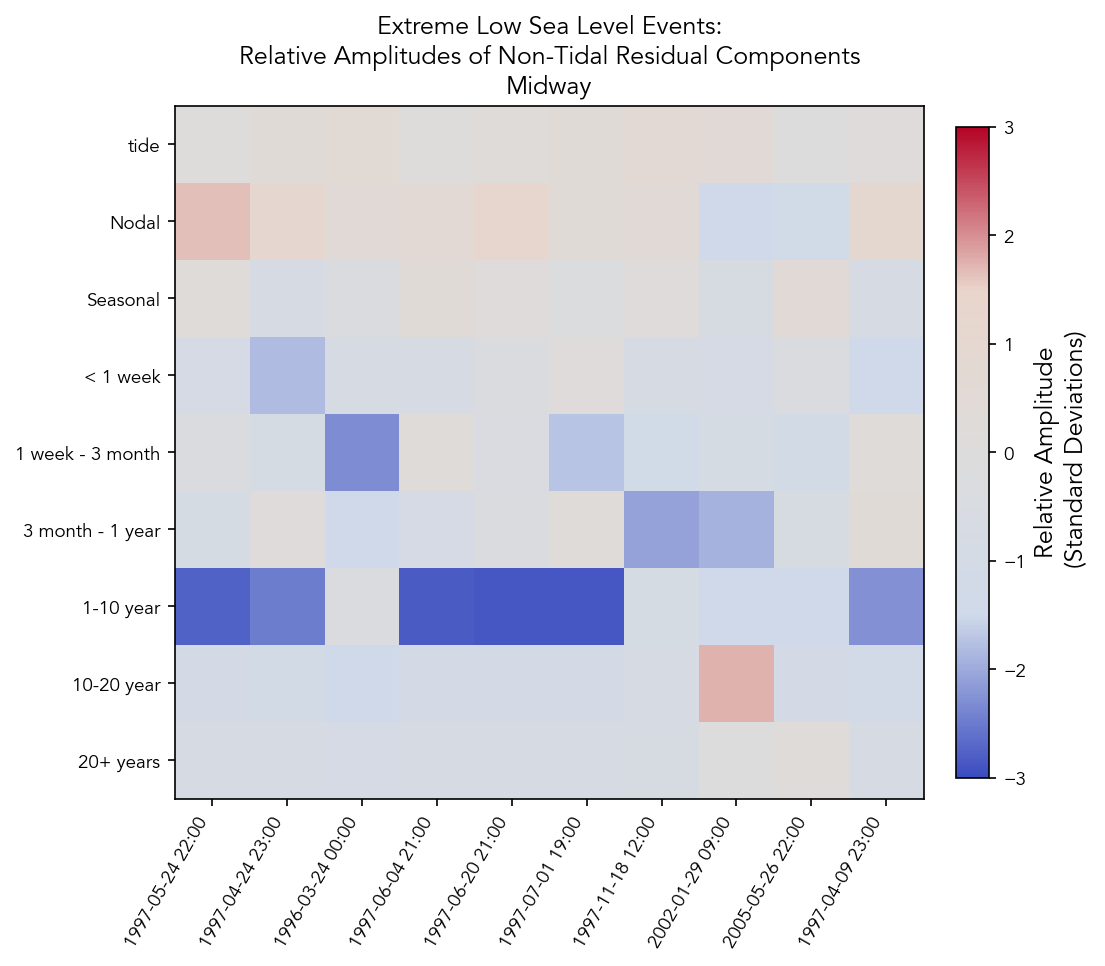

In [699]:
fig,ax = plot_component_amps(extremes_low_relative_to_std, high_or_low = 'low',station_name = station_name)

# save to output
output_path = output_dir / f'SL_rankings_NTR_relative_amplitudes_top10_{station_name}_low.png'
fig.savefig(output_path, bbox_inches='tight')


../output/SL_rankings_NTR_relative_amplitudes_top10_Midway_high.png


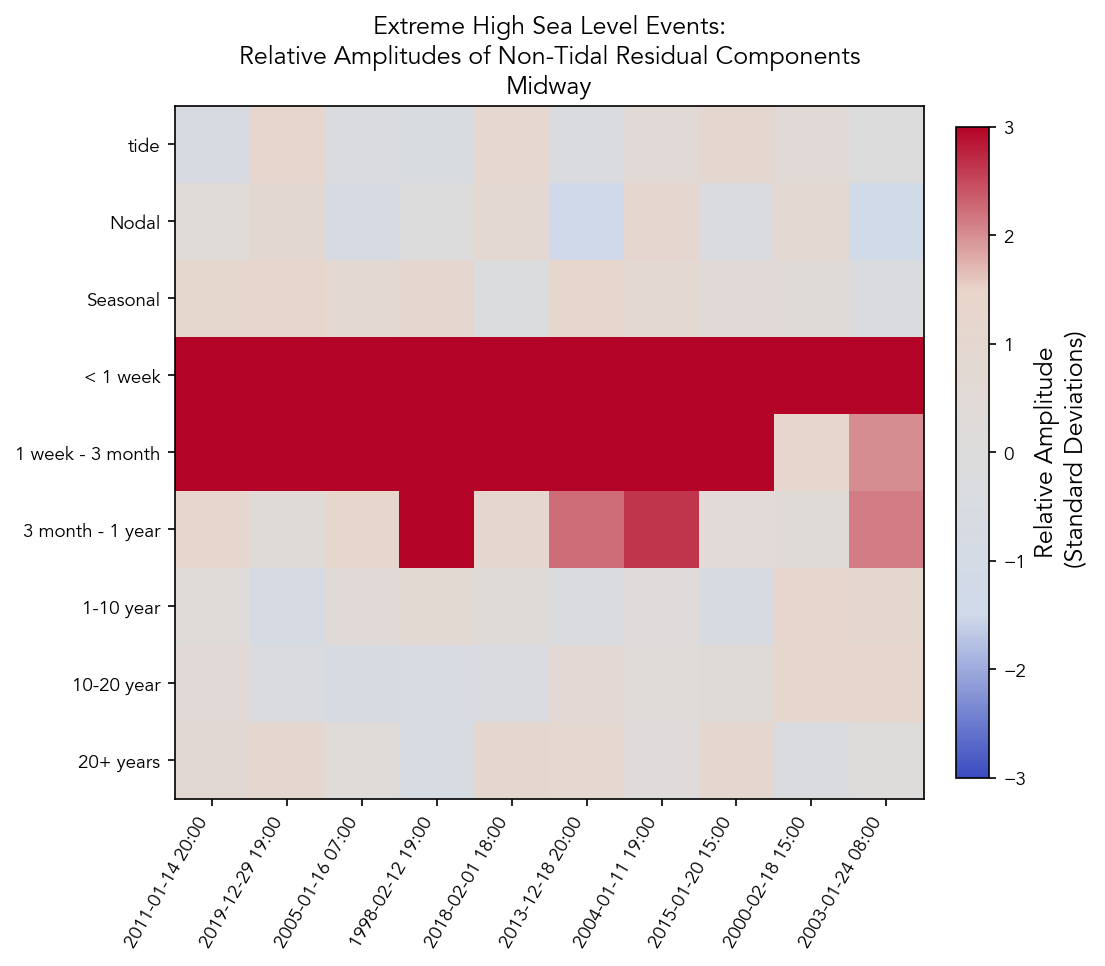

In [700]:
fig, ax = plot_component_amps(extremes_high_relative_to_std, high_or_low = 'high',station_name = station_name)
# save to output
output_path = output_dir / f'SL_rankings_NTR_relative_amplitudes_top10_{station_name}_high.png'

print(output_path)
fig.savefig(output_path, bbox_inches='tight')